<img src="https://raw.githubusercontent.com/SmilodonCub/DATA620/master/starwars.png" width="100%" style="margin-left:auto; margin-right:auto">

<br>

# Project 1

DATA 620
Bonnie Cooper, George Cruz Deschamps, Rob Hodde

<br>

## Assignment Information

For your first project, you are asked to

* Identify and load a network dataset that has some categorical information available for each node.
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
* Compare your centrality measures across your categorical groups.

For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.  

<br>

## Environment

In [1]:
from ctypes import alignment
from pyvis.network import Network
import pandas as pd
import pickle
from pathlib import Path
import urllib
import collections
from tqdm import tqdm
import os
import networkx as nx
import matplotlib.pyplot as plt
from pandas import DataFrame
import pandas as pd
import webbrowser

<br>

## Identify and load the Wookieepedia network dataset

For this assignment we will be visualizing a Star Wars data set. This dataset was generated by Dennis Bakhuis from web scrapings of the Wookieepedia website. [Wookieepedia](https://starwars.fandom.com/wiki/Main_Page) is the Star Wars wiki page which serves as an online encyclopedia for any and all things about the Star Wars universe. A full description of Dennis's methods are available on [his github](https://github.com/dennisbakhuis/wookieepediascience).  

### Star Wars network Nodes

To begin, we will load a dataframe of Star Wars characters. These characters will eventually become the nodes of the Star Wars network:

In [2]:
# read in the StarWars_Characters dataframe
characters = pd.read_parquet('data\StarWars_Characters.parquet')

In [40]:
print( characters.shape )
characters.head()

(5334, 14)


,name,key,url,description,species_2nd,species_3rd,species,home_world,gender,height,eye_color,skin_color,hair_color,weight
0,1138 (First Order),1138_(First_Order),https://starwars.fandom.com/wiki/1138_(First_O...,1138 was a human male stormtrooper who served ...,None,None,Human,None,Male,NaN,None,None,None,None
1,1151,1151,https://starwars.fandom.com/wiki/1151,1151 was a clone cadet who was a part of the C...,None,None,Human,Kamino,Male,NaN,Brown,Tan,Black,None
2,1174,1174,https://starwars.fandom.com/wiki/1174,"1174, nicknamed ""Whiplash,"" was a clone troope...",None,None,Human,Kamino,Male,NaN,Brown,Tan,Black,None
3,224 (Coruscant Security Force),224_(Coruscant_Security_Force),https://starwars.fandom.com/wiki/224_(Coruscan...,224 was the designation of a human male office...,None,None,Human,None,Male,NaN,None,Light,None,None
4,3-6,3-6,https://starwars.fandom.com/wiki/3-6,3-6 was a male death trooper in DT-F16's squad...,None,None,Human,None,Male,NaN,None,None,None,None


In [41]:
characters[characters['name']=='Yoda']

,name,key,url,description,species_2nd,species_3rd,species,home_world,gender,height,eye_color,skin_color,hair_color,weight
5227,Yoda,Yoda,https://starwars.fandom.com/wiki/Yoda,"Yoda, a Force-sensitive male being belonging t...",None,None,Yoda's species,Yoda's homeworld,Male,0.66,Green-gold,Green,White,13 kilograms


<br>

#### About the Star Wars characters dataframe

There are 5334 characters described by this data set. each character's information is given in a row of the dataframe. The output directly above shows the record for the character 'Yoda'. This information was scraped directly from selected fields of [Yoda's Wookieepedia page](https://starwars.fandom.com/wiki/Yoda). 



In [42]:
characters.iloc[5227]['description']

'Yoda, a Force-sensitive male being belonging to a mysterious species, was a legendary Jedi Master who witnessed the rise and fall of the Galactic Republic, followed by the rise of the Galactic Empire. Small in stature but revered for his wisdom and power, Yoda trained generations of Jedi, ultimately serving as the Grand Master of the Jedi Order. Having lived through nine centuries of galactic history, he played integral roles in the Clone Wars, the rebirth of the Jedi through Luke Skywalker, and unlocking the path to immortality.\n'

Below is a screenshot from Yoda's Wookieepedia page to convince ourselves of the origin of the data

<img src="https://raw.githubusercontent.com/SmilodonCub/DATA620/master/yodapic.png" width="80%" style="margin-left:auto; margin-right:auto">

<br>  

### Star Wars network edges

The characters in this previous dataframe will serve as the nodes in our Star Wars network. However, to really build the graph network, we need information about the connectivity between the nodes. For that we will turn to a different data set which, again, was originally scraped by [Dennis Bakhuis](https://github.com/dennisbakhuis/wookieepediascience).  

The following code is adapted from Dennis' wonderfully documented notebooks. Here we go back to raw data collected from the initial scraping process. We are interested in a field called 'crosslinks'. Crosslinks lists all other entities that a linked to a page. This will be used to establish a relationship between characters.

In [3]:
# go through 6 different pickle files downloaded from Dennis' github

files = sorted(Path('data').glob('*.pickle'))
data = {}
# for each of the 6 files: open, read & add to the data dictionary
for fn in files:
    with open(fn, 'rb') as f:
        part = pickle.load(f)
    data.update(part)

# a helper function to format urls
def remove_url_shizzle(text):
    return urllib.parse.unquote(text).replace('"', '').replace("'", '')

cleaned = {}
#for every key/value pair in data
for key, value in tqdm(data.items()):
    #let's make a niver to read key
    new_key = remove_url_shizzle(key)
    #set value (a dict) as the values for the new cleaned key
    cleaned[new_key] = value
    #format the 'crosslinks' key
    cleaned[new_key]['crosslinks'] = [remove_url_shizzle(crosslink) for crosslink in value['crosslinks']]
data = cleaned

100%|██████████| 29860/29860 [00:01<00:00, 16478.97it/s]


In [44]:
len( data.keys() )

29858

We can see that there are ~30k sets of cennections to evaluates from the raw data.  
Below we can see the some information for Yoda's entry:

In [45]:
print( data['Yoda'].keys() )
print( data['Yoda']['paragraph'] )
print( data['Yoda']['crosslinks'] )
print( len(data['Yoda']['crosslinks'] ))

dict_keys(['url', 'title', 'is_character', 'side_bar', 'paragraph', 'crosslinks'])
Yoda, a Force-sensitive male being belonging to a mysterious species, was a legendary Jedi Master who witnessed the rise and fall of the Galactic Republic, followed by the rise of the Galactic Empire. Small in stature but revered for his wisdom and power, Yoda trained generations of Jedi, ultimately serving as the Grand Master of the Jedi Order. Having lived through nine centuries of galactic history, he played integral roles in the Clone Wars, the rebirth of the Jedi through Luke Skywalker, and unlocking the path to immortality.

['The_Gathering', 'Behavioral_modification_biochip', 'Akar-Deshu', 'CT-5555', 'Alliance_to_Restore_the_Republic', 'Chewbacca', 'Darth', 'Ezra_Bridger', 'Jedi', 'Army', 'Starlight_Beacon', 'Immortality', 'Jedi_Knight', 'Nightsisters', 'Skywalker_family', 'Lothal', 'Veter', 'Swamp', 'Count', 'Cloning', 'Huyang', 'Battle_of_Endor', 'Separatist_Droid_Army', 'Kamino', 'Kashyyyk', 'M

<br>  

Wow! Those are a lot of crosslinks!   
This is not all that surprizing. Afterall, Yoda is a main character throughout much of the Star Wars saga.  

Let's look at the crosslinks for a lesser known character:  

In [46]:
print( data['Ming_Po']['crosslinks'] )
print( len(data['Ming_Po']['crosslinks'] ))

['Human', 'Carlac', 'Outer_Rim_Territories', 'Homeworld', 'Planet', 'Color', 'Tryla', 'Canon', 'Sentience']
9


<br>  

The following code will step through the crosslinks for each key in the data dict. Then, it will evaluate whether the crosslink is a character. If the crosslink is between characters, this will be added to the graph network.

In [47]:
characters_list = pd.read_parquet('data/StarWars_Characters.parquet')['key'].tolist()

In [48]:
#ainstantiate a .Graph() object
graph = nx.Graph()
# for every key in characters
for key in tqdm(characters_list):
    #use this key from characters to get the crosslinks from data
    crosslinks = data[key]['crosslinks']
    # for each crosslink
    for crosslink in crosslinks:
        # if the crosslink is to a character, 
        # then this connection describes a connection between characters
        if crosslink in characters_list:
            # add to the .Graph object
            graph.add_edge(key, crosslink)

print(f'Nodes: {graph.number_of_nodes()}, Links: {graph.number_of_edges()}')

100%|██████████| 5334/5334 [00:28<00:00, 188.78it/s]

Nodes: 4794, Links: 19599


In [49]:
# taking a look at our graph object

# list a few nodes
print( list(graph.nodes)[0:10] )
print(graph.edges('Saw_Gerrera') )

['1151', 'Crasher', 'Mace_Windu', 'Boba_Fett', 'Kilian', '1174', '224_(Coruscant_Security_Force)', 'Asajj_Ventress', '3-6', 'Saw_Gerrera']
[('Saw_Gerrera', '3-6'), ('Saw_Gerrera', 'Ahsoka_Tano'), ('Saw_Gerrera', 'Akshaya_Ponta'), ('Saw_Gerrera', 'Alexsandr_Kallus'), ('Saw_Gerrera', 'Althin'), ('Saw_Gerrera', 'Anakin_Skywalker'), ('Saw_Gerrera', 'Arane_Oreida'), ('Saw_Gerrera', 'Arro_Basteren'), ('Saw_Gerrera', 'Auromae_Iselo'), ('Saw_Gerrera', 'Baze_Malbus'), ('Saw_Gerrera', 'Beezer_Fortuna'), ('Saw_Gerrera', 'Benthic'), ('Saw_Gerrera', 'Berk'), ('Saw_Gerrera', 'Bilder'), ('Saw_Gerrera', 'Bodhi_Rook'), ('Saw_Gerrera', 'Bodhi_Rooks_mother'), ('Saw_Gerrera', 'Bokk_Naarg'), ('Saw_Gerrera', 'Bor_Gullet'), ('Saw_Gerrera', 'Brom_Titus'), ('Saw_Gerrera', 'Brunson'), ('Saw_Gerrera', 'Cal_Kestis'), ('Saw_Gerrera', 'Cassian_Jeron_Andor'), ('Saw_Gerrera', 'Caysin_Bog'), ('Saw_Gerrera', 'Chirrut_Îmwe'), ('Saw_Gerrera', 'Choyyssyk'), ('Saw_Gerrera', 'Chussido'), ('Saw_Gerrera', 'Codo'), ('Saw_Gerre

<br>

### Star Wars Categorical Information

For this assignment, we are interested in visualizing a network with categorical infromation about the nodes. In the Star Wars universe there is a very obvious dichotomy: the light and dark side of the force. However, because the actual number of Jedi and Sith is a relatively small subset of the characters, we will be more broad in our characterization: the (relatively) good guys (Jedi/Resistance/Republic) and the bad guys (Sith/Empire/First Order etc.).  

But how to do this? This information is not a given in the dataset prepared for us.  
Let's see what we can do....

In [50]:
print( 'Total entities to evalaute: ',len( data.keys() ) )
print( data['BB-8'].keys())
print( '' )
print( 'Looking at the data for one of the entries: ')
print( 'Sidebar keys: ',data['BB-8']['side_bar'].keys())
print( 'Chronological and political information values: ', data['BB-8']['side_bar']['Chronological and political information'] )

Total entities to evalaute:  29858
dict_keys(['url', 'title', 'is_character', 'side_bar', 'paragraph', 'crosslinks'])

Looking at the data for one of the entries: 
Sidebar keys:  dict_keys(['Production information', 'Technical specifications', 'Chronological and political information'])
Chronological and political information values:  {'Affiliation': ['New Republic', 'Rapier Squadron', 'Resistance', 'Black Squadron', 'Exegol landing team']}


<br>

The field 'Chronological and political information' holds a key value pair for 'Affiliations'

Let's take a look at the affiliations for the character Yoda:

In [51]:
print( data['Yoda']['side_bar']['Chronological and political information']['Affiliation(s)'] )

['Jedi Order', 'Jedi High Council', 'Galactic Republic', 'Grand Army of the Republic']


In [52]:
affiliations = []
for key in tqdm(characters_list):
    try:
        #turns out wookieepedia has the attributes listed as different headers on different character pages, 
        # so we need to try both `Affiliation` and `Affiliation(s)` ¯\_(ツ)_/¯ 
        if 'Affiliation' in data[key]['side_bar']['Chronological and political information']:
            affiliation = data[key]['side_bar']['Chronological and political information']['Affiliation']
            affiliations.append( affiliation )
        elif 'Affiliation(s)' in data[key]['side_bar']['Chronological and political information']:
            affiliation = data[key]['side_bar']['Chronological and political information']['Affiliation(s)']
            affiliations.append( affiliation )
    except:
        # if there was nothing there, append an empty list
        affiliations.append( [] )

100%|██████████| 5334/5334 [00:00<00:00, 533731.36it/s]


We see that Yoda is affiliated with several Jedi related organizations.  

For our analysis, we will use the affiliations of a character to determine whether they are one of the 'good guys', one of the 'bad guys' or a neutral character.  

Here is the strategy:  

1. get the set of all possible affiliations
2. for each affiliation, determine if it is good (1), bad (-1) or neutral (0)
3. for each character calculate the character's affiliation score as $\sum_0^n{\frac{\mbox{affiliation scores}}{n}}$ where $n$ is the number of affiliations for a character


#### (1) All possible affiliations
Let's get started by compiling the set of affiliations:

In [53]:
# the result is a little messy (some are stirngs some are lists).
# let's clean

print( len( affiliations ) )
cleaned_affiliations = []

for item in affiliations:
    if isinstance(item, str):
        cleaned_affiliations.append( item )
    elif type(item)==list:
        cleaned_affiliations.extend( item )
        
#remove duplicates to have a set of affiliations
print( len( cleaned_affiliations ) )
cleaned_affiliations = list( set(cleaned_affiliations))
print( len( cleaned_affiliations ) )

5271
8171
1224


We started with 5271 records of affiliations. Once we flatten all the lists of affiliations, we end up with 8171 total. However, if we select the set of unique affiliation, we have a more manageable list of 1224.

#### (2) Characterizing the Affiliations

There are 1224 possible affiliations.  
What we need: a good (1), bad (-1) or neutral (0) score for each entity on the affiliations set.  
How did we get this data?: we asked Star Wars nerds.  

The 1224 entities were scored by self-proclaimed 'experts' (Nerds with nothing better to do on a President's Day weekend). The data was divided into batches of ~250 and each subset was assigned to an expert. The experts were directed to assign a score to each entity. If they felt confident in assigning a score without referenceing Wookieepedia, they were free to do so. Otherwise, they were encouraged use the Wookieepedia content to inform a decision. The results were collated into the following csv: 

In [54]:
# load the csv
affiliations_scores = pd.read_csv( 'data/affiliation_scores.csv' )
affiliations_scores.head()

,Score,Organization
0,1,Alliance to Restore the Republic
1,1,Danger Squadron
2,1,501st Legion
3,1,"""Reb"" Squadron"
4,0,Han Solo's shipping company


In [55]:
# recast the columns as a python dict
aff_dict = {affiliations_scores['Organization'][i]: affiliations_scores['Score'][i] for i in range(len(affiliations_scores['Organization']))}

In [56]:
aff_dict["Han Solo's shipping company"]

0

<br>

#### (3) Character's Affiliation Score

Now to find the affiliation score for each character node in out graph object and to add thier result as an attribute to the node

In [57]:
# functionalize getting the score
def calc_affiliation_score( affiliation_entry, scores_dict ):
    """
    this function will take the dictionary value for either 'Affilition' of 'Affiliation(s)' 
    from the 'Chronological and political information' field.
    will evaluate whether the entry is a string or list of strings
    will then calculate the node's score as the mean of the affiliation scores 
    """
    if isinstance(affiliation_entry, str):
        score = scores_dict[ affiliation_entry ]
    elif type(affiliation_entry)==list and len(affiliation_entry)>=2:
        scores = [scores_dict[entity] for entity in affiliation_entry]
        score = sum( scores )/len(scores)
    else:
        score = float("NaN")
        
    return score

#functionalize assigning the outcome
def cal_affiliation( score ):
    """
    will take a score (e.g. calculated by `calc_affiliation_score`),
    will assign an outcome based on the following criteria:
    'good' > 0
    'neutral' = 0
    'bad' < 0
    """
    if score == 0:
        res = 'neutral'
    elif score > 0:
        res = 'good'
    elif score < 0:
        res = 'bad'
    return res

In [58]:
exp_aff =  ['Jedi Order', 'Sith', 'Confederacy of Independent Systems', 'Nightsisters', "Krayt's Claw"]
res = calc_affiliation_score( exp_aff, aff_dict )
res

-0.2

In [59]:
data_keys = list( data.keys() )
#affiliations = []
for node in graph.nodes:
    if node in data_keys:
        try: 
            if 'Affiliation' in data[node]['side_bar']['Chronological and political information']:
                affiliation = data[node]['side_bar']['Chronological and political information']['Affiliation']
                score = calc_affiliation_score( affiliation, aff_dict )
                graph.nodes[node]['score'] = round( score, 2 )
                graph.nodes[node]['alignment'] = cal_affiliation( score )
            elif 'Affiliation(s)' in data[node]['side_bar']['Chronological and political information']:
                affiliation = data[node]['side_bar']['Chronological and political information']['Affiliation(s)']
                score = calc_affiliation_score( affiliation, aff_dict )
                graph.nodes[node]['score'] = round( score, 2 )
                graph.nodes[node]['alignment'] = cal_affiliation( score )
        except:
            score = float("NaN")
            graph.nodes[node]['score'] = score
            graph.nodes[node]['alignment'] = 'neutral'

Taking a look at some of the results from our calculations:

In [60]:
print('Hera_Syndulla: ')
print( graph.nodes['Hera_Syndulla'] )
print('Plo_Koon: ')
print( graph.nodes['Plo_Koon'] )
print('Mon_Mothma: ')
print( graph.nodes['Mon_Mothma'] )
print('Asajj_Ventress: ')
print( graph.nodes['Asajj_Ventress'] )
print('Savage_Opress: ')
print( graph.nodes['Savage_Opress'] )
print('Darth_Sidious: ')
print( graph.nodes['Darth_Sidious'] )

Hera_Syndulla: 
{'score': 1.0, 'alignment': 'good'}
Plo_Koon: 
{'score': 1.0, 'alignment': 'good'}
Mon_Mothma: 
{'score': 0.22, 'alignment': 'good'}
Asajj_Ventress: 
{'score': -0.2, 'alignment': 'bad'}
Savage_Opress: 
{'score': -0.75, 'alignment': 'bad'}
Darth_Sidious: 
{'score': -0.25, 'alignment': 'bad'}


In reviewing the results for the nodes above, we see results that agree with our understanding of the Star Wars universe. Hera Syndulla, Plo Koon and Mon Mothma, all characters that are agreeably `good` are given an alignment of `good`. Asajj Ventress, Savage Opress and Darth Sidious, all characters that are agreeably `bad`, are given an alignment of `bad`.

In [61]:
# pickling the graph object for later use
# nx.write_gpickle(graph, "data/SW_affiliations.gpickle")

<br>

## Good vs Bad Centrality 

For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.

In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
import pandas as pd

G = nx.read_gpickle('SW_affiliations.gpickle') #GET Bonnie's pickled Graph file of Force Alignment
f = nx.get_node_attributes(G, 'alignment')

*Calculate the Centrality metrics for the Star Wars character graph:*


*Connectedness is simply a count of the number of connections this character has to other characters.*

In [2]:
#CONNECTEDNESS  
lConnections = sorted(G.degree, key=lambda x: x[1], reverse=True) #create a sorted list of characters by number of connections
d = nx.degree(G) #needed to combine in table below
lConnections[:10]

[('Anakin_Skywalker', 807),
 ('Darth_Sidious', 577),
 ('Leia_Skywalker_Organa_Solo', 438),
 ('Obi-Wan_Kenobi', 433),
 ('Han_Solo', 430),
 ('Luke_Skywalker', 387),
 ('Ahsoka_Tano', 309),
 ('Chewbacca', 278),
 ('Padmé_Amidala', 258),
 ('Dooku', 246)]

*Closeness can be thought of as access efficiency. The closer a character is to another character, the more likely they will share information and may influence each other. See: *https://www.sciencedirect.com/science/article/abs/pii/S0378873315000738*

In [3]:
#CLOSENESS  calculate characters' closeness to each other
c=nx.closeness_centrality(G) #creates a dict of tuples, a=character, b=closeness  
lCloseness = [(k,v) for k,v in c.items()]  #characters and closeness as a list 
lCloseness.sort(key=lambda x: x[1], reverse=True) #sort the list by the 2nd column
lCloseness[:10]

[('Anakin_Skywalker', 0.4598071793327266),
 ('Darth_Sidious', 0.4532995777244018),
 ('Leia_Skywalker_Organa_Solo', 0.43303463064958153),
 ('Luke_Skywalker', 0.4319688828875969),
 ('Han_Solo', 0.4195773486682166),
 ('Obi-Wan_Kenobi', 0.41544592997275226),
 ('Chewbacca', 0.4057272225956735),
 ('Wilhuff_Tarkin', 0.4045675744396284),
 ('Yoda', 0.4022680521059965),
 ('Ahsoka_Tano', 0.4018259993014844)]

*Betweenness measures others' dependence on the character. A high betweenness character supplies many other characters with information or other resources.* 

In [4]:
#BETWEENNESS  determine which characters are information brokers
b = nx.betweenness_centrality(G)
lBetween =  [(k,v) for k,v in b.items()]
lBetween.sort(key=lambda x: x[1], reverse=True)
lBetween[:10]

[('Anakin_Skywalker', 0.18009922132577508),
 ('Darth_Sidious', 0.14252910130378244),
 ('Leia_Skywalker_Organa_Solo', 0.10553189611475562),
 ('Han_Solo', 0.08376494893553196),
 ('Luke_Skywalker', 0.08265852589189979),
 ('Obi-Wan_Kenobi', 0.055277633339127934),
 ('Ahsoka_Tano', 0.040666295449070425),
 ('The_Smuggler', 0.04020378312322475),
 ('Chewbacca', 0.03680158904352428),
 ('Wilhuff_Tarkin', 0.03649277491584748)]

*Eigenvector centrality is a measure of the influence a node has on a network.*
*See: https://en.wikipedia.org/wiki/Eigenvector_centrality*

In [5]:
#EIGENVECTOR CENTRALITY  determine which characters are most powerful
e = nx.eigenvector_centrality(G)
lEigen =  [(k,v) for k,v in e.items()]
lEigen.sort(key=lambda x: x[1], reverse=True)
lEigen[:10]

[('Anakin_Skywalker', 0.3091087395792395),
 ('Darth_Sidious', 0.24853137909239073),
 ('Obi-Wan_Kenobi', 0.20392112224976564),
 ('Leia_Skywalker_Organa_Solo', 0.15950507403080189),
 ('Ahsoka_Tano', 0.15733070885706887),
 ('Luke_Skywalker', 0.15567154308809952),
 ('Han_Solo', 0.13796045302050802),
 ('Padmé_Amidala', 0.1353117080047803),
 ('Dooku', 0.13112407135587448),
 ('Wilhuff_Tarkin', 0.12008273979172673)]

*Now merge the four centrality measures plus the Good/Neutral/Bad classification into a single list of the top 100 characters in each centrality measure:*

In [8]:
#Combine into one list
names1=[x[0] for x in lConnections[:100]] #get first column (character name) of Top 100 values for each metric
names2=[x[0] for x in lCloseness[:100]]
names3=[x[0] for x in lBetween[:100]]
names4=[x[0] for x in lEigen[:100]]
names = list(set(names1) | set(names2) | set(names3) | set(names4))  #make a list of distinct character names from the lists 
table=[[name, d[name], c[name], b[name], e[name], f[name]] for name in names] #join centrality measures to character names

*Arrange the data so that plots can be made comparing the Alignment patterns (Good/Bad/Neutral):*

In [9]:
#Convert data to a dataframe and give column heading names
df = pd.DataFrame(table)
df.columns = ['Name','Connectedness','Closeness','Betweenness','Eigen Centrality', 'Alignment']
df.head(10)

,Name,Connectedness,Closeness,Betweenness,Eigen Centrality,Alignment
0,Norra_Wexley,66,0.354552,0.005287,0.039034,good
1,Ziro_Desilijic_Tiure,39,0.347505,0.001230,0.040295,bad
2,Sugi_(bounty_hunter),37,0.341740,0.000587,0.038128,neutral
3,Naare,22,0.352247,0.000513,0.027737,bad
4,Mosep_Binneed,13,0.327507,0.005868,0.013531,bad
5,Luke_Skywalker,387,0.431969,0.082659,0.155672,good
6,Wullf_Yularen,81,0.382625,0.005501,0.070198,bad
7,Mace_Windu,146,0.376292,0.009627,0.109095,good
8,Snoke,52,0.373569,0.004559,0.045449,bad
9,Ubrik_Adelhard,43,0.315929,0.004996,0.007928,bad


*Plot the response of each category to the other:*

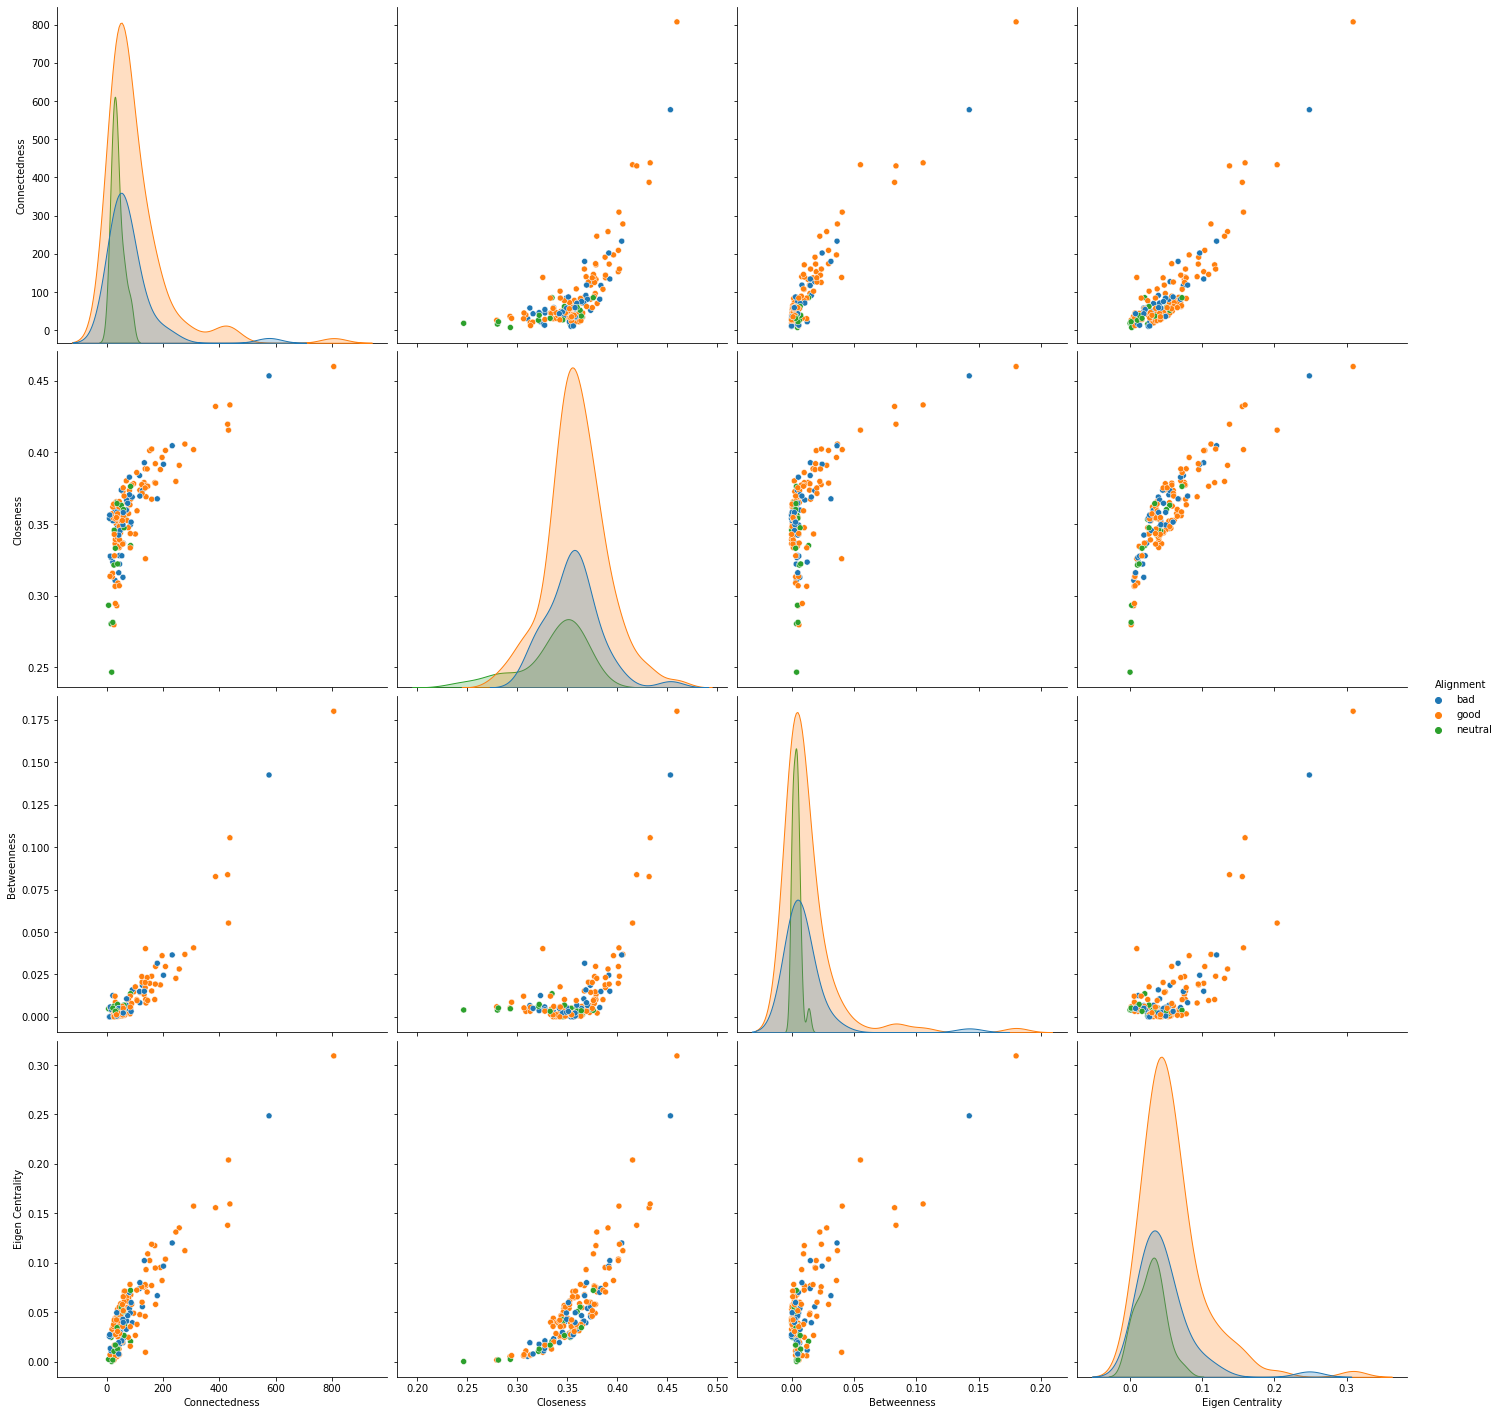

In [69]:
x = sns.pairplot(data=df, hue="Alignment", height=5)

*Notice that for all three Alignment classes: Good, Bad and Neutral, the response patterns are similar.*


*The little blue and amber dots on the top right quadrants of the centrality interaction charts above truly tell a most profound story.*
*The saga itself is the story of the life of Anakin Skywalker, born into slavery, rising as a Jedi learner, falling into the Dark Side as Vader, and eventually redeeming himself.*
*It is a story of good triumphing over evil. Let's take a closer look at those little blue and amber dots.*

*We look at the bottom left chart -* Eigenvector Centrality Vs Connectedness.
*There are two extreme outlier dots representing the two most powerful characters in the saga: Anakin Skywalker, the story's protagonist, and Darth Sidious, the chief villain:*

In [70]:
lEigen[:2]

[('Anakin_Skywalker', 0.3091087395792395),
 ('Darth_Sidious', 0.24853137909239073)]

*Through patient and cunning political intrigue, Sidious rises from being a lowly Senator from a distant and inconsequential planet, to Supreme Chancellor, the most powerful political actor in the Galaxy, giving himself emergency powers, destroying the Jedi Order and crowning himself Emperor. For a generation he is successful in suppressing freedom across the Galaxy.*

*But the network analysis tells a different story. It says that Anakin is more powerful than Sidious. It says that Sidious, while commanding masses of low-power henchman, is, in a centrality framework, surrounded by the powerful good. And this is why he is eventually overthrown.*

*The Star Wars saga is a morality fable, and the moral is that when freedom is threatened, it is not enough to be good. Good people must respond powerfully to overcome evil.*

In [1]:
%%html
<iframe src="result.html" width="800" height="1000"></iframe>


Code for this graph is included in the p1.py file.